# 1. Data loading, Preprocessing, and EDA


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# create kaggle dir and read json file
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/

Mounted at /content/drive
cp: cannot stat '/content/drive/MyDrive/kaggle.json': No such file or directory


## 1.1: 1st Attempt: Joining Databases
We started out by using the same Kaggle dataset that the researched prior work used. There was a high volume of data but low dimensionality, in that there was only one feature that the model could be trained on. Our first contribution is to attempt to augment or expand this data.

### 1.1.1: Rainfall
Our Rainfall data is sourced from [this](https://www.kaggle.com/datasets/rajanand/rainfall-in-india) kaggle dataset. It goes from 1901-2015 and has monthly data for 36 meteorological subdivisions in India. Units are in millimeters of cumulative rainfall.

In [ ]:
# download & unzip kaggle dataset
!kaggle datasets download -d rajanand/rainfall-in-india
!unzip /content/rainfall-in-india.zip

rain_df = pd.read_csv('rainfall in india 1901-2015.csv')

# Check out the first five rows
rain_df.head()

Dataset URL: https://www.kaggle.com/datasets/rajanand/rainfall-in-india
License(s): CC-BY-SA-4.0
  0% 0.00/187k [00:00<?, ?B/s]
100% 187k/187k [00:00<00:00, 26.6MB/s]
Archive:  /content/rainfall-in-india.zip
  inflating: district wise rainfall normal.csv  
  inflating: rainfall in india 1901-2015.csv  


,SUBDIVISION,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,ANNUAL,Jan-Feb,Mar-May,Jun-Sep,Oct-Dec
0,ANDAMAN & NICOBAR ISLANDS,1901,49.2,87.1,29.2,2.3,528.8,517.5,365.1,481.1,332.6,388.5,558.2,33.6,3373.2,136.3,560.3,1696.3,980.3
1,ANDAMAN & NICOBAR ISLANDS,1902,0.0,159.8,12.2,0.0,446.1,537.1,228.9,753.7,666.2,197.2,359.0,160.5,3520.7,159.8,458.3,2185.9,716.7
2,ANDAMAN & NICOBAR ISLANDS,1903,12.7,144.0,0.0,1.0,235.1,479.9,728.4,326.7,339.0,181.2,284.4,225.0,2957.4,156.7,236.1,1874.0,690.6
3,ANDAMAN & NICOBAR ISLANDS,1904,9.4,14.7,0.0,202.4,304.5,495.1,502.0,160.1,820.4,222.2,308.7,40.1,3079.6,24.1,506.9,1977.6,571.0
4,ANDAMAN & NICOBAR ISLANDS,1905,1.3,0.0,3.3,26.9,279.5,628.7,368.7,330.5,297.0,260.7,25.4,344.7,2566.7,1.3,309.7,1624.9,630.8


In [ ]:
rain_df.shape

(4116, 19)

In [ ]:
rain_df.describe()

,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,ANNUAL,Jan-Feb,Mar-May,Jun-Sep,Oct-Dec
count,4116.000000,4112.000000,4113.000000,4110.000000,4112.000000,4113.000000,4111.000000,4109.000000,4112.000000,4110.000000,4109.000000,4105.000000,4106.000000,4090.000000,4110.000000,4107.000000,4106.000000,4103.000000
mean,1958.218659,18.957320,21.805325,27.359197,43.127432,85.745417,230.234444,347.214334,290.263497,197.361922,95.507009,39.866163,18.870580,1411.008900,40.747786,155.901753,1064.724769,154.100487
std,33.140898,33.585371,35.909488,46.959424,67.831168,123.234904,234.710758,269.539667,188.770477,135.408345,99.519134,68.685410,42.369611,903.846565,59.308277,201.316965,707.741531,166.942660
min,1901.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.400000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,62.300000,0.000000,0.000000,57.400000,0.000000
25%,1930.000000,0.600000,0.600000,1.000000,3.000000,8.600000,70.350000,175.600000,155.975000,100.525000,14.600000,0.700000,0.100000,804.500000,4.100000,24.050000,573.850000,34.200000
50%,1958.000000,6.000000,6.700000,7.800000,15.700000,36.600000,138.700000,284.800000,259.400000,173.900000,65.200000,9.500000,3.000000,1121.300000,19.200000,74.800000,881.100000,98.200000
75%,1987.000000,22.200000,26.800000,31.300000,49.950000,97.200000,305.150000,418.400000,377.800000,265.800000,148.400000,46.100000,17.500000,1644.775000,50.375000,196.950000,1288.175000,213.500000
max,2015.000000,583.700000,403.500000,605.600000,595.100000,1168.600000,1609.900000,2362.800000,1664.600000,1222.000000,948.300000,648.900000,617.500000,6331.100000,699.500000,1745.800000,4536.900000,1252.500000


In [ ]:
rain_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4116 entries, 0 to 4115
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   SUBDIVISION  4116 non-null   object 
 1   YEAR         4116 non-null   int64  
 2   JAN          4112 non-null   float64
 3   FEB          4113 non-null   float64
 4   MAR          4110 non-null   float64
 5   APR          4112 non-null   float64
 6   MAY          4113 non-null   float64
 7   JUN          4111 non-null   float64
 8   JUL          4109 non-null   float64
 9   AUG          4112 non-null   float64
 10  SEP          4110 non-null   float64
 11  OCT          4109 non-null   float64
 12  NOV          4105 non-null   float64
 13  DEC          4106 non-null   float64
 14  ANNUAL       4090 non-null   float64
 15  Jan-Feb      4110 non-null   float64
 16  Mar-May      4107 non-null   float64
 17  Jun-Sep      4106 non-null   float64
 18  Oct-Dec      4103 non-null   float64
dtypes: flo

In [ ]:
print(pd.unique(rain_df['SUBDIVISION']))
print("There are ", len(pd.unique(rain_df['SUBDIVISION'])), " meteorological subdivisions in this dataset.")

['ANDAMAN & NICOBAR ISLANDS' 'ARUNACHAL PRADESH' 'ASSAM & MEGHALAYA'
 'NAGA MANI MIZO TRIPURA' 'SUB HIMALAYAN WEST BENGAL & SIKKIM'
 'GANGETIC WEST BENGAL' 'ORISSA' 'JHARKHAND' 'BIHAR' 'EAST UTTAR PRADESH'
 'WEST UTTAR PRADESH' 'UTTARAKHAND' 'HARYANA DELHI & CHANDIGARH' 'PUNJAB'
 'HIMACHAL PRADESH' 'JAMMU & KASHMIR' 'WEST RAJASTHAN' 'EAST RAJASTHAN'
 'WEST MADHYA PRADESH' 'EAST MADHYA PRADESH' 'GUJARAT REGION'
 'SAURASHTRA & KUTCH' 'KONKAN & GOA' 'MADHYA MAHARASHTRA' 'MATATHWADA'
 'VIDARBHA' 'CHHATTISGARH' 'COASTAL ANDHRA PRADESH' 'TELANGANA'
 'RAYALSEEMA' 'TAMIL NADU' 'COASTAL KARNATAKA' 'NORTH INTERIOR KARNATAKA'
 'SOUTH INTERIOR KARNATAKA' 'KERALA' 'LAKSHADWEEP']
There are  36  meteorological subdivisions in this dataset.


,Total,Percent
ANNUAL,26,0.631681
Oct-Dec,13,0.315841
NOV,11,0.267250
Jun-Sep,10,0.242954
DEC,10,0.242954
Mar-May,9,0.218659
JUL,7,0.170068
OCT,7,0.170068
MAR,6,0.145773
Jan-Feb,6,0.145773


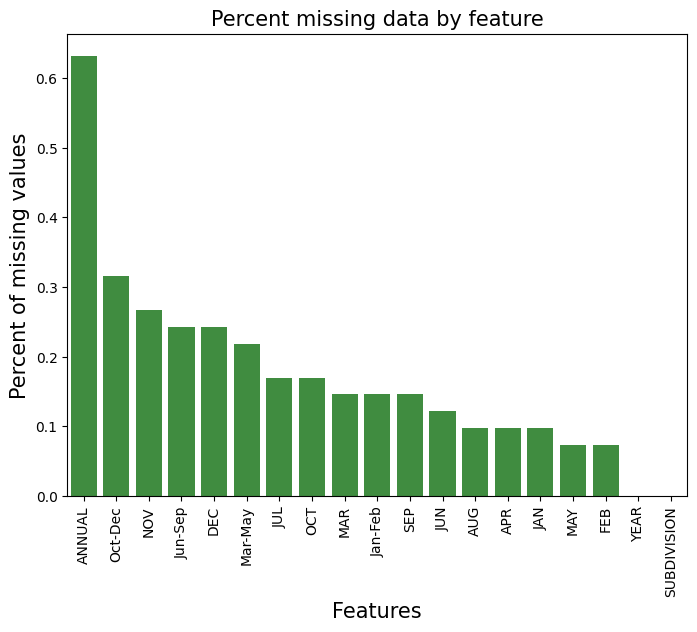

In [ ]:
def missingdata(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    ms = pd.concat([total,percent],axis = 1,keys = ['Total','Percent'])
    ms = ms[ms['Percent']>=0]
    f,ax = plt.subplots(figsize=(8,6))
    plt.xticks(rotation = 'vertical')
    fig =  sns.barplot(ms['Percent'],color = 'green',alpha = 0.8)
    plt.xlabel('Features',fontsize = 15)
    plt.ylabel('Percent of missing values', fontsize = 15)
    plt.title('Percent missing data by feature', fontsize = 15)
    return ms
missingdata(rain_df)

Basic Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4116 entries, 0 to 4115
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   SUBDIVISION  4116 non-null   object 
 1   YEAR         4116 non-null   int64  
 2   JAN          4112 non-null   float64
 3   FEB          4113 non-null   float64
 4   MAR          4110 non-null   float64
 5   APR          4112 non-null   float64
 6   MAY          4113 non-null   float64
 7   JUN          4111 non-null   float64
 8   JUL          4109 non-null   float64
 9   AUG          4112 non-null   float64
 10  SEP          4110 non-null   float64
 11  OCT          4109 non-null   float64
 12  NOV          4105 non-null   float64
 13  DEC          4106 non-null   float64
 14  ANNUAL       4090 non-null   float64
 15  Jan-Feb      4110 non-null   float64
 16  Mar-May      4107 non-null   float64
 17  Jun-Sep      4106 non-null   float64
 18  Oct-Dec      4103 non-null   

,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,ANNUAL,Jan-Feb,Mar-May,Jun-Sep,Oct-Dec
count,4116.000000,4112.000000,4113.000000,4110.000000,4112.000000,4113.000000,4111.000000,4109.000000,4112.000000,4110.000000,4109.000000,4105.000000,4106.000000,4090.000000,4110.000000,4107.000000,4106.000000,4103.000000
mean,1958.218659,18.957320,21.805325,27.359197,43.127432,85.745417,230.234444,347.214334,290.263497,197.361922,95.507009,39.866163,18.870580,1411.008900,40.747786,155.901753,1064.724769,154.100487
std,33.140898,33.585371,35.909488,46.959424,67.831168,123.234904,234.710758,269.539667,188.770477,135.408345,99.519134,68.685410,42.369611,903.846565,59.308277,201.316965,707.741531,166.942660
min,1901.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.400000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,62.300000,0.000000,0.000000,57.400000,0.000000
25%,1930.000000,0.600000,0.600000,1.000000,3.000000,8.600000,70.350000,175.600000,155.975000,100.525000,14.600000,0.700000,0.100000,804.500000,4.100000,24.050000,573.850000,34.200000
50%,1958.000000,6.000000,6.700000,7.800000,15.700000,36.600000,138.700000,284.800000,259.400000,173.900000,65.200000,9.500000,3.000000,1121.300000,19.200000,74.800000,881.100000,98.200000
75%,1987.000000,22.200000,26.800000,31.300000,49.950000,97.200000,305.150000,418.400000,377.800000,265.800000,148.400000,46.100000,17.500000,1644.775000,50.375000,196.950000,1288.175000,213.500000
max,2015.000000,583.700000,403.500000,605.600000,595.100000,1168.600000,1609.900000,2362.800000,1664.600000,1222.000000,948.300000,648.900000,617.500000,6331.100000,699.500000,1745.800000,4536.900000,1252.500000



Frequency of Unique Values for Categorical Columns:

Frequency of top unique values in SUBDIVISION:
SUBDIVISION
WEST MADHYA PRADESH    115
EAST RAJASTHAN         115
COASTAL KARNATAKA      115
TAMIL NADU             115
RAYALSEEMA             115
Name: count, dtype: int64


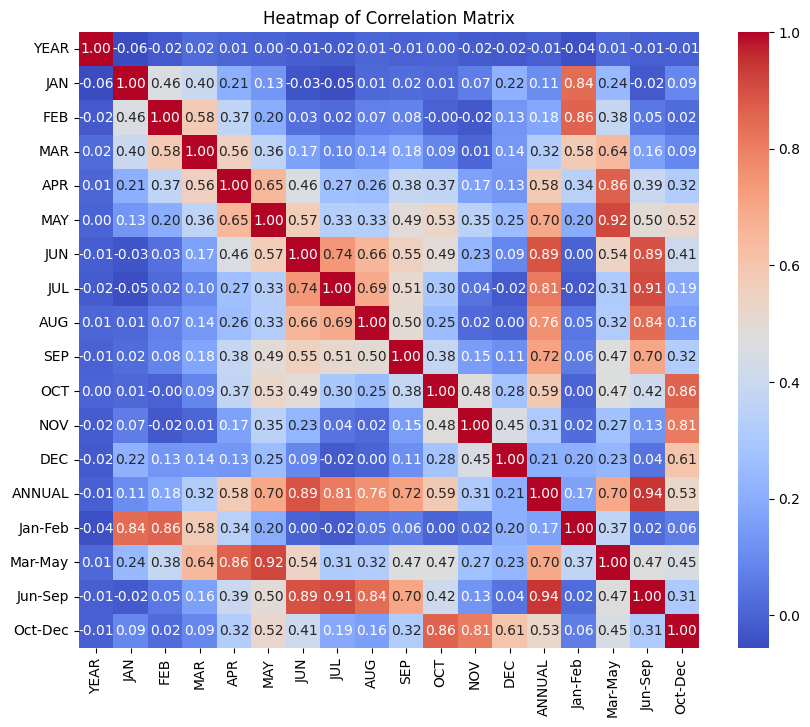

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_dataset(df):
    # Display basic information and the shape of the dataset
    print("Basic Information:")
    print(df.info())
    print("\nShape of the dataset:", df.shape)

    # Display unique counts for each column
    print("\nUnique values count:")
    for col in df.columns:
        print(f"{col}: {df[col].nunique()} unique values")

    # Summary statistics for numerical columns
    print("\nSummary Statistics for Numeric Columns:")
    display(df.describe())

    # Frequency of unique values for categorical data
    print("\nFrequency of Unique Values for Categorical Columns:")
    for col in df.select_dtypes(include=['object']).columns:
        print(f"\nFrequency of top unique values in {col}:")
        print(df[col].value_counts().head())

    # Visualizing distributions of numerical features
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    # for col in numeric_cols:
    #     plt.figure(figsize=(10, 5))
    #     sns.histplot(df[col].dropna(), kde=True)
    #     plt.title(f'Distribution of {col}')
    #     plt.xlabel(col)
    #     plt.ylabel('Frequency')
    #     plt.show()
    # numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    # for col in numeric_cols:
    #     plt.figure(figsize=(10, 5))
    #     if df[col].nunique() < 20:  # If column has fewer unique values, treat as categorical
    #         sns.countplot(x=col, data=df)
    #     else:  # For continuous data, we create bins
    #         bins = np.linspace(df[col].min(), df[col].max(), 20)  # Adjust number of bins as needed
    #         df[col + '_binned'] = pd.cut(df[col], bins=bins, include_lowest=True, labels=[f'{int(bins[i])}-{int(bins[i+1])}' for i in range(len(bins)-1)])
    #         sns.countplot(x=col + '_binned', data=df)
    #         plt.xticks(rotation=45)  # Rotate labels for better readability
    #     plt.title(f'Distribution Bar Plot of {col}')
    #     plt.ylabel('Frequency')
    #     plt.show()

    # if len(numeric_cols) > 1:  # Only plot if there are at least two numeric columns
    #   for i in range(len(numeric_cols)):
    #       for j in range(i + 1, len(numeric_cols)):
    #           plt.figure(figsize=(10, 6))
    #           sns.scatterplot(x=numeric_cols[i], y=numeric_cols[j], data=df)
    #           plt.title(f'Scatter Plot between {numeric_cols[i]} and {numeric_cols[j]}')
    #           plt.xlabel(numeric_cols[i])
    #           plt.ylabel(numeric_cols[j])
    #           plt.show()

    # # Visualizing categorical data with a count plot
    # categorical_cols = df.select_dtypes(include=['object']).columns
    # for col in categorical_cols:
    #     if df[col].nunique() < 20:  # To avoid creating too massive plots
    #         plt.figure(figsize=(12, 6))
    #         sns.countplot(x=col, data=df, order = df[col].value_counts().index)
    #         plt.title(f'Count Plot for {col}')
    #         plt.xticks(rotation=45)
    #         plt.show()

    # # Visualizing distributions of numerical features using scatter plots
    # numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    # for col in numeric_cols:
    #     plt.figure(figsize=(10, 6))
    #     freq = df[col].value_counts().sort_index()
    #     sns.scatterplot(x=freq.index, y=freq.values)
    #     plt.title(f'Scatter Plot of Frequencies for {col}')
    #     plt.xlabel(col)
    #     plt.ylabel('Frequency')
    #     plt.show()

    # Visualizing the correlation matrix with a heatmap
    if len(numeric_cols) > 1:
        plt.figure(figsize=(10, 8))
        corr = df[numeric_cols].corr()
        sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
        plt.title('Heatmap of Correlation Matrix')
        plt.show()

        #sns.clustermap(corr)

analyze_dataset(rain_df)


<Axes: >

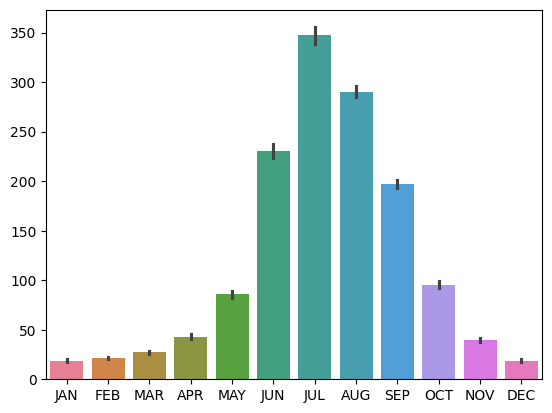

In [ ]:
#rain_df.describe().iloc[1,1:13]
sns.barplot(rain_df.iloc[:,2:14])

### 1.1.2 Temperature
We found Temperature data sourced from [this](https://data.gov.in/catalog/all-india-seasonal-and-annual-temperature-series) data catalogue from the website of the Indian Government. While it has monthly granularity from 1901-2021 and has min/max/mean data, it does not have data for each subdivision but represents India as a whole. Data is in Celsius.

In [ ]:
max_t_path = '/content/drive/My Drive/CIS 519/TEMP_ANNUAL_MAX_1901-2021.csv'
max_t_df = pd.read_csv(max_t_path)

min_t_path = '/content/drive/My Drive/CIS 519/TEMP_ANNUAL_MIN_1901-2021.csv'
min_t_df = pd.read_csv(min_t_path)

mean_t_path = '/content/drive/My Drive/CIS 519/TEMP_ANNUAL_MEAN_1901-2021.csv'
mean_t_df = pd.read_csv(mean_t_path)

In [ ]:
max_t_df.head()

,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,ANNUAL,JAN-FEB,MAR-MAY,JUN-SEP,OCT-DEC
0,1901.0,24.17,26.02,30.87,33.99,35.02,34.44,31.83,30.5,31.24,31.18,28.42,25.83,30.29,25.1,33.29,32,28.48
1,1902.0,26.28,27.99,31.77,33.58,35.11,33.89,31.52,31.23,30.29,30.21,27.74,25.19,30.4,27.14,33.49,31.73,27.71
2,1903.0,24.83,26.54,29.9,33.53,34.72,34.04,31.75,30.4,30.37,30.06,27.35,25.11,29.88,25.68,32.72,31.64,27.51
3,1904.0,24.64,26.42,30.14,33.67,34.18,32.9,30.72,30.61,30.83,30.56,27.75,25.2,29.8,25.53,32.67,31.27,27.83
4,1905.0,23.63,23.83,28.51,31.87,34.89,34.37,31.66,30.89,30.83,31.17,28.82,25.48,29.66,23.73,31.75,31.93,28.49


In [ ]:
max_t_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 18 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   YEAR     121 non-null    float64
 1   JAN      123 non-null    object 
 2   FEB      123 non-null    object 
 3   MAR      123 non-null    object 
 4   APR      123 non-null    object 
 5   MAY      123 non-null    object 
 6   JUN      123 non-null    object 
 7   JUL      123 non-null    object 
 8   AUG      123 non-null    object 
 9   SEP      123 non-null    object 
 10  OCT      123 non-null    object 
 11  NOV      123 non-null    object 
 12  DEC      123 non-null    object 
 13  ANNUAL   123 non-null    object 
 14  JAN-FEB  123 non-null    object 
 15  MAR-MAY  123 non-null    object 
 16  JUN-SEP  123 non-null    object 
 17  OCT-DEC  123 non-null    object 
dtypes: float64(1), object(17)
memory usage: 17.8+ KB


In [ ]:
min_t_df.drop([121,122],axis=0,inplace = True)
min_t_df

,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,ANNUAL,JAN-FEB,MAR-MAY,JUN-SEP,OCT-DEC
0,1901.0,14.46,15.76,19.02,22.45,24.5,25.26,24.64,24.17,23.22,21.48,17.42,14.28,20.55,15.11,21.99,24.32,17.73
1,1902.0,14.06,15.17,19.69,22.72,24.88,25.05,24.47,24.2,23.24,20.44,17.12,14.35,20.45,14.61,22.43,24.24,17.31
2,1903.0,13.74,14.87,17.94,21.82,24.22,25.02,24.89,23.92,23.62,21.31,16.66,13.5,20.13,14.3,21.33,24.37,17.16
3,1904.0,13.75,14.23,18.67,22.55,24.17,24.71,24,23.91,22.85,20.77,16.57,14.53,20.06,13.99,21.8,23.87,17.29
4,1905.0,13.05,12.91,17.78,20.65,24.58,25.37,24.6,24.41,23.49,21.52,17.67,14.1,20.01,12.98,21,24.47,17.76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,2017.0,14.02,16.13,19.02,23.01,24.84,24.88,24.57,24.35,23.83,21.84,17.66,15.02,20.76,15.08,22.29,24.41,18.17
117,2018.0,13.39,16.14,19.58,22.59,24.46,25.12,24.67,24.23,23.35,20.83,18.05,14.4,20.57,14.76,22.21,24.34,17.76
118,2019.0,13.37,15.88,18.75,22.89,24.74,25.45,24.91,24.37,23.89,21.62,18.9,15.21,20.83,14.63,22.13,24.66,18.58
119,2020.0,14.3,15.82,19.06,22.36,24.45,24.81,24.77,24.73,24.08,21.89,17.79,15.06,20.76,15.06,21.96,24.6,18.25


In [ ]:
max_t_df.drop([121,122,123,124,125],axis=0,inplace = True)
max_t_df

,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,ANNUAL,JAN-FEB,MAR-MAY,JUN-SEP,OCT-DEC
0,1901.0,24.17,26.02,30.87,33.99,35.02,34.44,31.83,30.5,31.24,31.18,28.42,25.83,30.29,25.1,33.29,32,28.48
1,1902.0,26.28,27.99,31.77,33.58,35.11,33.89,31.52,31.23,30.29,30.21,27.74,25.19,30.4,27.14,33.49,31.73,27.71
2,1903.0,24.83,26.54,29.9,33.53,34.72,34.04,31.75,30.4,30.37,30.06,27.35,25.11,29.88,25.68,32.72,31.64,27.51
3,1904.0,24.64,26.42,30.14,33.67,34.18,32.9,30.72,30.61,30.83,30.56,27.75,25.2,29.8,25.53,32.67,31.27,27.83
4,1905.0,23.63,23.83,28.51,31.87,34.89,34.37,31.66,30.89,30.83,31.17,28.82,25.48,29.66,23.73,31.75,31.93,28.49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,2017.0,26.11,29.24,31.46,34.9,35.99,33.83,31.8,31.65,32.22,32.25,29.38,26.89,31.31,27.67,34.12,32.38,29.51
117,2018.0,26.41,29.02,32.45,34.37,35.53,34.03,31.71,31.22,31.91,32.01,29.63,26.41,31.22,27.72,34.12,32.22,29.35
118,2019.0,25.86,27.72,31.08,34.74,35.81,35.07,32.4,31.46,31.24,30.81,28.97,25.44,30.88,26.79,33.88,32.54,28.4
119,2020.0,24.99,28.04,30.47,33.91,35.23,33.41,32.31,31.53,31.98,32.03,29.17,26.59,30.81,26.51,33.2,32.31,29.26


In [ ]:
min_t_df = min_t_df.astype(float)
min_t_df['YEAR'] = min_t_df['YEAR'].astype(int)
min_t_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121 entries, 0 to 120
Data columns (total 18 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   YEAR     121 non-null    int64  
 1   JAN      121 non-null    float64
 2   FEB      121 non-null    float64
 3   MAR      121 non-null    float64
 4   APR      121 non-null    float64
 5   MAY      121 non-null    float64
 6   JUN      121 non-null    float64
 7   JUL      121 non-null    float64
 8   AUG      121 non-null    float64
 9   SEP      121 non-null    float64
 10  OCT      121 non-null    float64
 11  NOV      121 non-null    float64
 12  DEC      121 non-null    float64
 13  ANNUAL   121 non-null    float64
 14  JAN-FEB  121 non-null    float64
 15  MAR-MAY  121 non-null    float64
 16  JUN-SEP  121 non-null    float64
 17  OCT-DEC  121 non-null    float64
dtypes: float64(17), int64(1)
memory usage: 17.1 KB


In [ ]:
max_t_df = max_t_df.astype(float)
max_t_df['YEAR'] = max_t_df['YEAR'].astype(int)
max_t_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121 entries, 0 to 120
Data columns (total 18 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   YEAR     121 non-null    int64  
 1   JAN      121 non-null    float64
 2   FEB      121 non-null    float64
 3   MAR      121 non-null    float64
 4   APR      121 non-null    float64
 5   MAY      121 non-null    float64
 6   JUN      121 non-null    float64
 7   JUL      121 non-null    float64
 8   AUG      121 non-null    float64
 9   SEP      121 non-null    float64
 10  OCT      121 non-null    float64
 11  NOV      121 non-null    float64
 12  DEC      121 non-null    float64
 13  ANNUAL   121 non-null    float64
 14  JAN-FEB  121 non-null    float64
 15  MAR-MAY  121 non-null    float64
 16  JUN-SEP  121 non-null    float64
 17  OCT-DEC  121 non-null    float64
dtypes: float64(17), int64(1)
memory usage: 17.1 KB


## 1.2: Webscraping Data

Set up basic predictions using data from [this colab notebook](https://colab.research.google.com/drive/1D4Hh3-_Ss4Qzj6LmcNdz8m0klSElGa5a?usp=drive_open#scrollTo=thge1kithWC_)

In [ ]:
proj_data = pd.read_csv('/content/drive/MyDrive/CIS 519/Data/data_clean.csv')

### 1.2.1 Data Formatting
Make sure data is in good format for models to use. (mostly just coverting strings to cat numbers, and using feature transformation.)

In [ ]:
proj_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4884 entries, 0 to 4883
Data columns (total 32 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   region                      4884 non-null   object 
 1   year                        4884 non-null   int64  
 2   month                       4884 non-null   object 
 3   temp_max_C                  4884 non-null   float64
 4   temp_avg_daily_max_C        4884 non-null   float64
 5   temp_min_daily_max_C        4884 non-null   float64
 6   temp_max_daily_avg_C        4884 non-null   float64
 7   temp_avg_C                  4884 non-null   float64
 8   temp_min_daily_avg_C        4884 non-null   float64
 9   temp_max_daily_min_C        4884 non-null   float64
 10  temp_avg_daily_min_C        4884 non-null   float64
 11  temp_min_C                  4884 non-null   float64
 12  dew_pt_max_C                4884 non-null   float64
 13  dew_pt_avg_C                4884 

Convert unique subdivisions into numbers so the models dont have to worry about string

In [ ]:
#convert all uniuque subdivision to integer
proj_data['region'] = pd.Categorical(proj_data['region'])
proj_data['region'] = proj_data['region'].cat.codes



print(proj_data['region'])
proj_data['region'] = proj_data['region'].astype(float)
proj_data.head()

0        0
1        0
2        0
3        0
4        0
        ..
4879    36
4880    36
4881    36
4882    36
4883    36
Name: region, Length: 4884, dtype: int8


,region,year,month,temp_max_C,temp_avg_daily_max_C,temp_min_daily_max_C,temp_max_daily_avg_C,temp_avg_C,temp_min_daily_avg_C,temp_max_daily_min_C,...,snow_depth_sum_mm,wind_max_kmh,wind_avg_kmh,wind_min_kmh,gust_max_kmh,gust_avg_kmh,gust_min_kmh,sea_level_preassure_max_mb,sea_level_preassure_avg_mb,sea_level_preassure_min_mb
0,0.0,2010,january,28.0,27.55,27.0,28.0,27.42,27.0,28.0,...,0.0,26.0,17.71,10.0,35.0,24.71,15.0,5.3,0.90,0.0
1,0.0,2010,february,28.0,27.54,26.0,28.0,27.46,26.0,28.0,...,0.0,23.0,15.68,7.0,31.0,21.68,10.0,0.0,0.00,0.0
2,0.0,2010,march,30.0,28.48,27.0,30.0,28.39,27.0,29.0,...,0.0,19.0,10.13,4.0,27.0,14.10,6.0,1.5,0.14,0.0
3,0.0,2010,april,30.0,29.73,29.0,30.0,29.67,29.0,30.0,...,0.0,13.0,7.00,4.0,18.0,9.63,5.0,2.5,0.42,0.0
4,0.0,2010,may,31.0,30.45,30.0,31.0,30.26,30.0,31.0,...,0.0,38.0,16.35,3.0,57.0,23.52,4.0,30.1,4.81,0.0


Convert month from str to number

In [ ]:
from calendar import month_name
lower_ma = [m.lower() for m in month_name]

proj_data['month'] = proj_data['month'].str.lower().map(lambda m: lower_ma.index(m)).astype('float64')
proj_data.head()

,region,year,month,temp_max_C,temp_avg_daily_max_C,temp_min_daily_max_C,temp_max_daily_avg_C,temp_avg_C,temp_min_daily_avg_C,temp_max_daily_min_C,...,snow_depth_sum_mm,wind_max_kmh,wind_avg_kmh,wind_min_kmh,gust_max_kmh,gust_avg_kmh,gust_min_kmh,sea_level_preassure_max_mb,sea_level_preassure_avg_mb,sea_level_preassure_min_mb
0,0.0,2010,1.0,28.0,27.55,27.0,28.0,27.42,27.0,28.0,...,0.0,26.0,17.71,10.0,35.0,24.71,15.0,5.3,0.90,0.0
1,0.0,2010,2.0,28.0,27.54,26.0,28.0,27.46,26.0,28.0,...,0.0,23.0,15.68,7.0,31.0,21.68,10.0,0.0,0.00,0.0
2,0.0,2010,3.0,30.0,28.48,27.0,30.0,28.39,27.0,29.0,...,0.0,19.0,10.13,4.0,27.0,14.10,6.0,1.5,0.14,0.0
3,0.0,2010,4.0,30.0,29.73,29.0,30.0,29.67,29.0,30.0,...,0.0,13.0,7.00,4.0,18.0,9.63,5.0,2.5,0.42,0.0
4,0.0,2010,5.0,31.0,30.45,30.0,31.0,30.26,30.0,31.0,...,0.0,38.0,16.35,3.0,57.0,23.52,4.0,30.1,4.81,0.0


In [ ]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import model_selection
from sklearn import linear_model
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, precision_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error


In [ ]:
proj_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4884 entries, 0 to 4883
Data columns (total 32 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   region                      4884 non-null   float64
 1   year                        4884 non-null   int64  
 2   month                       4884 non-null   float64
 3   temp_max_C                  4884 non-null   float64
 4   temp_avg_daily_max_C        4884 non-null   float64
 5   temp_min_daily_max_C        4884 non-null   float64
 6   temp_max_daily_avg_C        4884 non-null   float64
 7   temp_avg_C                  4884 non-null   float64
 8   temp_min_daily_avg_C        4884 non-null   float64
 9   temp_max_daily_min_C        4884 non-null   float64
 10  temp_avg_daily_min_C        4884 non-null   float64
 11  temp_min_C                  4884 non-null   float64
 12  dew_pt_max_C                4884 non-null   float64
 13  dew_pt_avg_C                4884 

drop all precipitation type columns, and scale/transform features

In [ ]:
regressionFeatures = proj_data.columns.drop(['precipitation_sum_mm','precipitation_max_mm','precipitation_avg_mm','precipitation_min_mm', 'snow_depth_max_mm','snow_depth_avg_mm','snow_depth_min_mm','snow_depth_sum_mm'])
df_regressionFeatures = pd.DataFrame(data=MinMaxScaler().fit_transform(proj_data[regressionFeatures]), columns=regressionFeatures)

In [ ]:
features = regressionFeatures
target = 'precipitation_sum_mm'

0        28.0
1         0.0
2         4.2
3        12.5
4       149.1
        ...  
4879    247.2
4880    249.4
4881     80.4
4882      0.3
4883      0.0
Name: precipitation_sum_mm, Length: 4884, dtype: float64
avg:  86.60112612612613
max:  2038.8
min:  0.0


(array([4.276e+03, 3.990e+02, 1.260e+02, 4.500e+01, 1.900e+01, 7.000e+00,
        6.000e+00, 4.000e+00, 1.000e+00, 1.000e+00]),
 array([   0.  ,  203.88,  407.76,  611.64,  815.52, 1019.4 , 1223.28,
        1427.16, 1631.04, 1834.92, 2038.8 ]),
 <BarContainer object of 10 artists>)

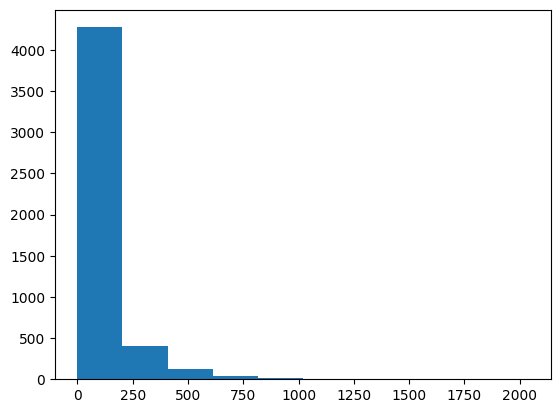

In [ ]:
# make sure target is what we want, as well as very basic info
print(proj_data['precipitation_sum_mm'])
print('avg: ',np.mean(proj_data['precipitation_sum_mm']))
print('max: ',np.max(proj_data['precipitation_sum_mm']))
print('min: ',np.min(proj_data['precipitation_sum_mm']))
plt.hist(proj_data['precipitation_sum_mm'])

In [ ]:
seed = 42
train, test = train_test_split(proj_data, test_size=0.2, random_state=seed)
train, val = train_test_split(train, test_size=0.2, random_state=seed)

need to do k-fold cross instead eventually, but to check against existing models this is good.

In [ ]:
X_train, X_val, X_test = train[features], val[features], test[features]
y_train, y_val, y_test = train[target], val[target], test[target]

# Baseline Model Comparison

Compare the open-source models with our data against the data they used. This will tell us how much increasing the feature space helps prediction.

try using open-sources model([git-hub](https://github.com/vgaurav3011/Rainfall-Prediction)), the first model they used was a elastic net (or linear reg with $L_1$ and $L_2$ regularization). From the low-dim data they used they were able to get a MAE of 94.99.

In [ ]:
from sklearn import linear_model
reg = linear_model.ElasticNet(alpha=0.5)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
print('MAE: ', mean_absolute_error(y_test, y_pred))

MAE:  2.146983385388078


the second model from [git-hub](https://github.com/vgaurav3011/Rainfall-Prediction). Next,they used RandomForestRegressor and were able to obtain MAE of
85.69.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 100, max_depth=10, n_jobs=1, verbose=2)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print('MAE: ', mean_absolute_error(y_test, y_pred))

building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.2s


building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s


Next, the same source used a SVR and were able to achieve MAE: 127.7

In [ ]:
from sklearn.svm import SVR
clf = SVR(gamma='auto', C=0.1, epsilon=0.2)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
mean_absolute_error(y_test, y_pred)

82.44218204725642

Next, they used linear regression with only ridge regularization, and achieved a MAE of 94.9

In [ ]:
from sklearn.linear_model import Ridge
rdf = Ridge(alpha = 0.5, tol = 0.001, solver = 'auto', random_state = 42)
rdf.fit(X_train, y_train)
y_pred = rdf.predict(X_test)
mean_absolute_error(y_test, y_pred)

1.549367084084016

Looks like using a dataset with a larger feature space helped a lot. Next, we can hyperparameter tune to further improve our predictions.

## Hyper-param tuning using sklearns GridSearchCV

In [ ]:

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor




# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}

# Create the estimator
estimator = RandomForestRegressor()

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator, param_grid, cv=5)

# Fit the data to perform the grid search
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Print the best parameters and best score
print("Best Parameters:", best_params)
print("Best Score:", best_score)



Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}
Best Score: 0.9973313854111368


See [this notebook for testing models, and hyperparam tuning](https://colab.research.google.com/drive/13lDQaJWC1w1BtRqZAIWS9DQomB-2G6NJ#scrollTo=aR2XwS2W-76_)